# Keras OCR 공개구현체의 Recognizer(CRNN모델) Fine-tuning 실습

이 예제에서는 본인만의 데이터셋을 사용해서, Keras OCR 공개구현체에서 문자 인식을 수행하는 Recognizer를 Fine-tuning하는 실습을 수행합니다.

여기 예제에서는 [여기](https://rrc.cvc.uab.es/?ch=1&com=downloads)에서 다운로드 받을 수 있는 "Born Digital" 문자인식용 데이터셋으로 Fine-tuning을 수행합니다.

Copyright: https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html 의 공개구현체를 교육 목적에 맞게 수정 (2023.5.21, 김상호)

---

Keras OCR 라이브러리를 설치합니다.

In [3]:
!pip uninstall keras_ocr -y

Found existing installation: keras-ocr 0.0.0
Uninstalling keras-ocr-0.0.0:
  Successfully uninstalled keras-ocr-0.0.0


In [4]:
!pip install -e ./keras_ocr

Obtaining file:///home/kyudan/sanghokimprof_project/keras_ocr
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for keras-ocr (pyproject.toml) ... done
  Created wheel for keras-ocr: filename=keras_ocr-0.0.0-py3-none-any.whl size=5151 sha256=332052c635c9c976ee721c3737fe7ffd163dd035cd86cd1cdd4721462c3c2ed2
  Stored in directory: /tmp/pip-ephem-wheel-cache-40t3lxkk/wheels/ad/45/7c/4ec1f6de25cd05fa69561da5e7b6b2ab6e4f8c113fc5996f02
Successfully built keras-ocr

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import keras_ocr
print(keras_ocr.__file__)

2024-12-13 03:12:57.429180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 03:12:57.437780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734027177.446832   75221 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734027177.449541   75221 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 03:12:57.459392: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

/home/kyudan/sanghokimprof_project/keras_ocr/keras_ocr/__init__.py


In [2]:
import keras_ocr
import imgaug

import random
import string
import math
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

tf.config.list_physical_devices() # Check H/W accellerator type

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

keras_ocr 내장 함수를 사용하여 "Born Digital" 데이터셋을 다운로드 받습니다.

"Born Digital"데이터셋에는 train과 test데이터셋이 있지만, 이 예제에서는 train 데이터만 다운로드 받습니다. train 데이터셋은 아랫쪽에서 다시 training+validation 데이터셋으로 나눠서, training데이터셋으로 학습을 하고, 학습이 끝난 후에 검증은 validation 데이터셋으로 수행합니다. 

Label정보는 '/content/borndigital/train/gt.txt'에 담겨 있는데, Label(알파벳 단어)은 모두 lowercase로 바꿔줍니다.

* 용어 설명: **gt**는 **G**round **T**ruth의 준말로 지질학에서 실측자료라는 의미의 용어입니다. OCR분야에서 문자인식은 인간이 이미지 한장마다 모두  눈으로 '실측' 해서 라벨데이터를 만들기 때문에, Label을 Ground Truth라는 용어로 부릅니다. (반면에, Image Classification 분야에서는 label_map.pbtxt라는 이름을 사용했습니다.)

In [3]:
# Read "Born Digital" dataset
train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir='.'
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

#test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
#    split='test',
#    cache_dir='.'
#)
#test_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

Looking for ./borndigital/Challenge1_Training_Task3_Images_GT.zip


train_labels를 인쇄해서 어떤 형태로 구성되어 있는지 분석해봅니다. 

위의 keras_ocr 라이브러리의 get_born_digital_recognizer_dataset()함수를 참고해서,본인의 데이터셋을 읽어서 train_labels 형태로 return해주는 새로운 함수 get_mydata_recognizer_dataset() 함수를 만들어야 합니다.

In [4]:
train_labels

[('./borndigital/train/word_1.png', None, 'flying'),
 ('./borndigital/train/word_2.png', None, 'today'),
 ('./borndigital/train/word_3.png', None, 'means'),
 ('./borndigital/train/word_4.png', None, 'vueling'),
 ('./borndigital/train/word_5.png', None, 'get'),
 ('./borndigital/train/word_6.png', None, 'away,'),
 ('./borndigital/train/word_7.png', None, '1.000.000'),
 ('./borndigital/train/word_8.png', None, 'seats'),
 ('./borndigital/train/word_9.png', None, 'from'),
 ('./borndigital/train/word_10.png', None, '30€'),
 ('./borndigital/train/word_11.png', None, 'book'),
 ('./borndigital/train/word_12.png', None, 'now!'),
 ('./borndigital/train/word_13.png', None, 'smi'),
 ('./borndigital/train/word_14.png', None, 'sensomotoric'),
 ('./borndigital/train/word_15.png', None, 'instruments'),
 ('./borndigital/train/word_16.png', None, 'newsletter'),
 ('./borndigital/train/word_17.png', None, 'click'),
 ('./borndigital/train/word_18.png', None, 'play'),
 ('./borndigital/train/word_19.png', Non

In [5]:
type(train_labels)

list

In [6]:
train_labels[0]

('./borndigital/train/word_1.png', None, 'flying')

In [7]:
type(train_labels[0])

tuple

Recognizer를 Fine-tuning하는데 사용할 나만의 데이터를 Colab에 업로드하고, 업로드가 끝나면 아래 셀을 실행해서 압축을 풀어주세요.

keras_ocr의 get_born_digital_recognizer_dataset() 함수를 참고해서, 본인의 데이터셋을 읽어와서 위에서 분석한 train_labels와 같은 형태로 return해주는 함수를 정의해봅시다.

get_born_digital_recognizer_dataset() 함수는 아래의 code를 참고하면 됩니다.

* get_born_digital_recognizer_dataset()함수: https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/datasets.py#L128

In [8]:
import zipfile
import os


def get_mydata_recognizer_dataset (mother_dir, cache_dir):
  fin = []
  zipfile.ZipFile(cache_dir, 'r').extractall(f'{mother_dir}/extracted')
  with open(f'{mother_dir}/extracted/mydata_recognition_data/groundtruth.csv', 'r') as f:
      lines = f.readlines()
      #print(lines)
      for data in lines:
          data = data.replace('\n','')
          filename, something, gt = data.split(',')
          filename = f'{mother_dir}/extracted/mydata_recognition_data/images/{filename}'
          something = None
          gt = gt.lower()
          tup = (filename, something, gt)
          fin.append(tup)
  return fin


mother_dir = '.'
cache_dir = 'mydata_recognition_data.zip'

dataset = get_mydata_recognizer_dataset(mother_dir, cache_dir=cache_dir)
print(dataset)

[('./extracted/mydata_recognition_data/images/ak1165.png', None, 'fuw999'), ('./extracted/mydata_recognition_data/images/ak399.png', None, 'fgj235'), ('./extracted/mydata_recognition_data/images/ak721.png', None, 'fhg521'), ('./extracted/mydata_recognition_data/images/ak848.png', None, 'fpj331'), ('./extracted/mydata_recognition_data/images/al1156.png', None, '6a5730a'), ('./extracted/mydata_recognition_data/images/al1181.png', None, '26a178n'), ('./extracted/mydata_recognition_data/images/al1204.png', None, '9a9990a'), ('./extracted/mydata_recognition_data/images/al1247.png', None, '47a434f'), ('./extracted/mydata_recognition_data/images/al1259.png', None, 'kaa20c'), ('./extracted/mydata_recognition_data/images/al145.png', None, '47a8d4c'), ('./extracted/mydata_recognition_data/images/al1528.png', None, '1g3296b'), ('./extracted/mydata_recognition_data/images/al1662.png', None, '2a3633a'), ('./extracted/mydata_recognition_data/images/al47.png', None, '2a9043j'), ('./extracted/mydata_r

위에서 정의한 get_mydata_recognizer_dataset() 함수로 압축이 해제된 파일을 학습에 적합한 형태로 변환해줍니다.

In [9]:
mother_dir = '.'
cache_dir = 'mydata_recognition_data.zip'

train_labels = get_mydata_recognizer_dataset(mother_dir, cache_dir=cache_dir)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

train_labels가 의도한 포맷으로 나오는지 확인해 봅니다.

In [10]:
train_labels

[('./extracted/mydata_recognition_data/images/ak1165.png', None, 'fuw999'),
 ('./extracted/mydata_recognition_data/images/ak399.png', None, 'fgj235'),
 ('./extracted/mydata_recognition_data/images/ak721.png', None, 'fhg521'),
 ('./extracted/mydata_recognition_data/images/ak848.png', None, 'fpj331'),
 ('./extracted/mydata_recognition_data/images/al1156.png', None, '6a5730a'),
 ('./extracted/mydata_recognition_data/images/al1181.png', None, '26a178n'),
 ('./extracted/mydata_recognition_data/images/al1204.png', None, '9a9990a'),
 ('./extracted/mydata_recognition_data/images/al1247.png', None, '47a434f'),
 ('./extracted/mydata_recognition_data/images/al1259.png', None, 'kaa20c'),
 ('./extracted/mydata_recognition_data/images/al145.png', None, '47a8d4c'),
 ('./extracted/mydata_recognition_data/images/al1528.png', None, '1g3296b'),
 ('./extracted/mydata_recognition_data/images/al1662.png', None, '2a3633a'),
 ('./extracted/mydata_recognition_data/images/al47.png', None, '2a9043j'),
 ('./extra

Recognizer 모델을 Keras OCR 라이브러리를 사용해서 build하며,  Recognizer 모델의 초기 weights는 CRNN모델의 pre-trained weights를 자동으로 읽어옵니다. 

**Tip:** 아래 셀을 실행하기 전에 Colab에 'recognizer_mydata.h5'을 업로드하면, 초기 weights값을 업로드한 weights로 시작할 수 있습니다. 아래에서 1000번의 학습을 한번에 수행하지 않고, 여러번으로 나눠서 학습할 때에도 이 방법을 사용하면 됩니다.

In [53]:
# Build the recognizer model (CRNN architecture)
recognizer = keras_ocr.recognition.Recognizer()

# if any, load the recognizer model weights
model_weights = 'recognizer_borndigital.weights.h5'

"""if os.path.isfile(model_weights) == True:
  
  print(model_weights,': loaded successfully!')"""
recognizer.model.load_weights(model_weights)
recognizer.compile()

Looking for /home/kyudan/.keras-ocr/crnn_kurapan.h5


In [54]:
recognizer.training_model.optimizer.learning_rate.assign(0.00001)


<tf.Tensor: shape=(), dtype=float32, numpy=9.999999747378752e-06>

In [55]:
print(type(recognizer.training_model.optimizer.learning_rate))
print(recognizer.training_model.optimizer.learning_rate)

<class 'keras.src.backend.Variable'>
<Variable path=rmsprop/learning_rate, shape=(), dtype=float32, value=9.999999747378752e-06>


Fine-tuning학습 준비 과정으로, 위에서 읽은 train 데이터셋을 training:validation = 80%:20%로 나눠주고, training 데이터에 대해서 augmentation라이브러리의 gamma-correction을 적용해줍니다. Gammma-correction은 이미지의 contrast(제일 밝은 부분과 제일 어두운 부분의 대비)를 조정해주는 것입니다. Cropping, Rotation, Zoom 등의 다른 종류의 augmentation을 같이 적용해주고 싶다면 윗부분의 imgaug.augmenters.Sequential() 함수에 차례대로 넣어주면 됩니다.


In [56]:
# Splitting train dataset into training+validation sets
import imgaug.augmenters as iaa

batch_size = 8
augmenter = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.25, 3.0))
    
    
    #iaa.Dropout(p=(0, 0.1)),  # 픽셀 드롭아웃
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

제대로 학습용 데이터셋이 준비되었는지 Sanity check목적으로 training 데이터셋의 한 샘플을 뽑아서 이미지와 라벨을 화면에 표시해봅니다.

text: 271ldz


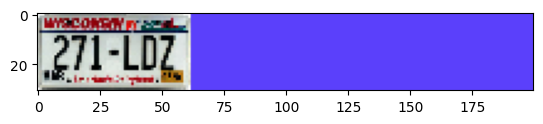

In [57]:
# Sanity check of training sample
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)

이제 1000번의 epoch동안 학습을 수행합니다. 아래 셀을 건너 뛰어서, 학습이 되기 전에 문자인식을 해보고, 다시 돌아와 학습을 수행한 후에 문자인식을 해보세요. 인식률의 차이를 살펴보기 바랍니다.

1000번의 학습차수(epoch)마다 Keras의 callback 라이브러리를 사용하여 아래 항목들을 수행합니다.(만일 제대로 실행되는지 확인만 하려면, epochs 횟수를 작은 숫자로 줄이기 바랍니다. 혹은, 10번으로 나눠서 학습을 하고싶다면, epochs 숫자를 100으로 줄여서 학습을 하고, 다시 학습을 시작할 때에 weights file을 Colab에 업로드하고 시작하는 방식으로 이어서 학습합니다)

1.   손실함수 값이 줄어들지 않으면 1000번 이전에 조기 종료시키는 early stopping
2.   학습된 weights를 지정된 checkpoint파일에 기록
3.  학습 과정을 지정된 csv 파일로 기록

Note: 2022.10월 시점에 아래 학습 코드가 잘 동작했으나, 2023.5월 시점에는 training_model.fit() 함수에서 "ValueError: Exception encountered when calling layer 'lambda_1' (type Lambda)" 에러가 발생하므로 아래의 조치가 필요함 (reference: https://github.com/faustomorales/keras-ocr/issues/231)

1.   keras_ocr 설치 패키지에 포함된 training.py 파일을 open
2.   'import tensorflow as tf' 아랫쪽에 'tf.compat.v1.disable_eager_execution()'와 'tf.compat.v1.experimental.output_all_intermediates(True)' 두개의 코드를 삽입하고, Ctrl+S로 저장
3. Colab-런타임-런타임다시시작 메뉴를 실행한 후에, 맨 위에서 두번째 코드인 import부분부터 다시 실행



In [58]:
# Run fine-tuning for 1000 epochs
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,
                                       filepath = 'recognizer_borndigital_third.weights.h5',
                                        monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital_12-2_third.csv'),
    
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-8
)
]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
)

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0568 - val_loss: 0.0225 - learning_rate: 1.0000e-05
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0665 - val_loss: 0.0173 - learning_rate: 1.0000e-05
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0476 - val_loss: 0.0245 - learning_rate: 1.0000e-05
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0674 - val_loss: 0.0162 - learning_rate: 1.0000e-05
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0441 - val_loss: 0.0232 - learning_rate: 1.0000e-05
Epoch 6/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0656 - val_loss: 0.0169 - learning_rate: 1.0000e-05
Epoch 7/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0474 - val_loss: 0.0163 - learning_rate: 1.0000e-05
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0547 - val_loss: 0.0234 - learning_rate: 1.0000e-06
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0385 - val_loss: 

학습이 잘 진행되었는지 validation 데이터셋에서 샘플 이미지를 선택해서 테스트를 진행해 봅니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Predicted: t2r, Actual: t2r


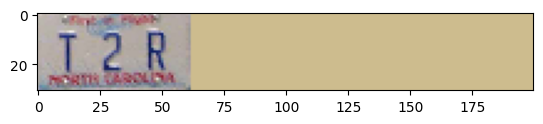

In [59]:
# Check fine-tuning results using a validation image sample
image_filepath, actual = next(validation_image_gen)
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

학습이 끝나면, 학습과정을 담고 있는 csv 로그 파일과, 학습결과 weights를 담고 있는 체크포인트 파일을 본인의 PC로 다운로드 받습니다.


---

### 학습된 Weights로 Validation 데이터를 추론해보기

1000번 학습이 완료된 'recognizer_mydata.h5' 파일을 Colab에 업로드해서 recognition test를 수행해 봅시다.

학습을 몇번만 진행한 것과 충분히 학습한 Recognizer의 추론 성능을 아래와 같이 비교해보세요.

1. 먼저, 위에서 학습을 진행하지 않거나 몇번 epoch만 학습을 진행하고 중단한 후에, 아래의 셀을 실행해서 추론 성능을 test합니다.
2. 다음에, 1000번 학습이 완료된 weights 파일('recognizer.mydata.h5')을 업로드하고, 위로 돌아가서 recognizer를 다시 build하고, 아래의 셀을 실행해서 추론 성능을 test합니다.

In [17]:
!mkdir mydata_recognition_result

mkdir: cannot create directory ‘mydata_recognition_result’: File exists


In [61]:
import imageio
import cv2

output_folder = 'mydata_recognition_result'
right = 0
for image_path, _, actual in validation_labels:
    predicted = recognizer.recognize(image_path)
    
    output_image_path = os.path.join(output_folder, image_path.split('/')[-1])

    image = keras_ocr.tools.read(image_path)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, f'gt: {actual}', (10,40), font, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(image, f'pd: {predicted}', (10,20), font, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imwrite(output_image_path, image)

    if actual == predicted:
        right = right +1

score = right/len(validation_labels)
print(score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━

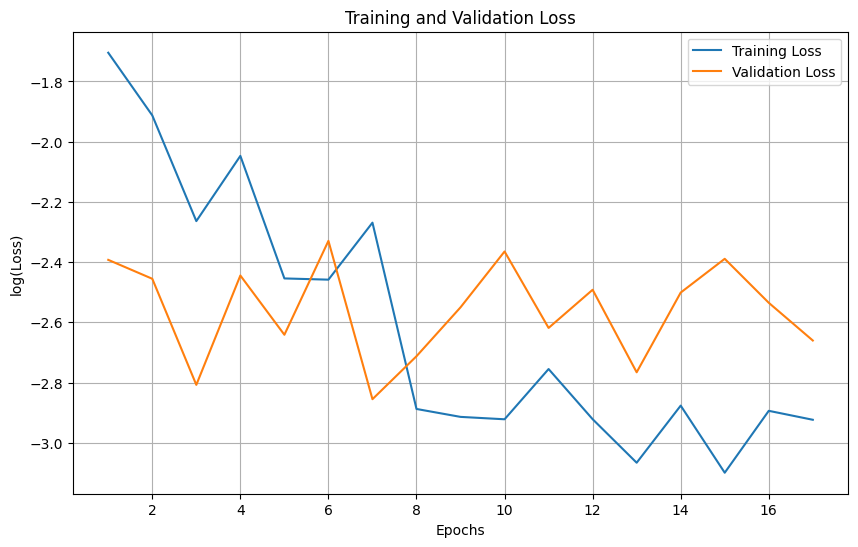

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# CSV 파일 경로
csv_path = os.path.join('.', 'recognizer_borndigital_12-2.csv')

# CSV 파일 읽기
data = pd.read_csv(csv_path)

# Training loss와 Validation loss 데이터 가져오기
training_loss = np.log(data['loss'])
validation_loss = np.log(data['val_loss'])
epochs = range(1, len(training_loss) + 1)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('log(Loss)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


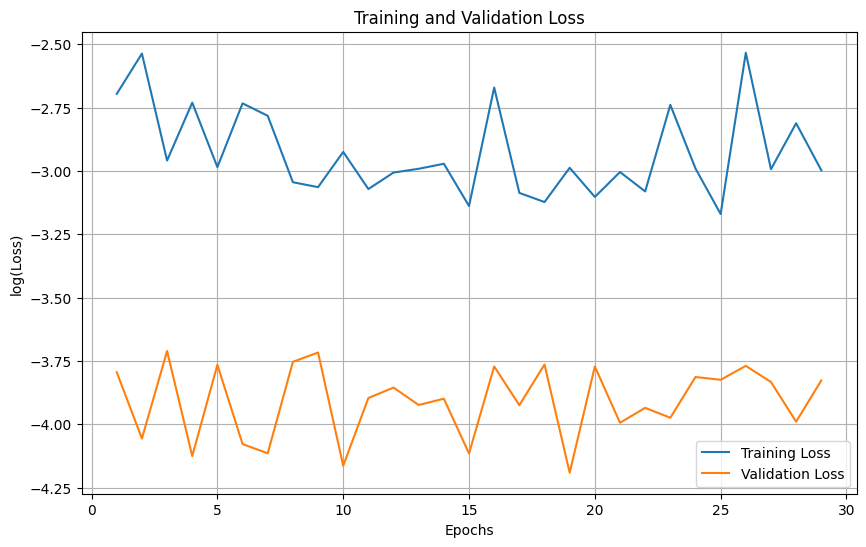

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# CSV 파일 경로
csv_path = os.path.join('.', 'recognizer_borndigital_12-2_third.csv')

# CSV 파일 읽기
data = pd.read_csv(csv_path)

# Training loss와 Validation loss 데이터 가져오기
training_loss = np.log(data['loss'])
validation_loss = np.log(data['val_loss'])
epochs = range(1, len(training_loss) + 1)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('log(Loss)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
